In [1]:
import os
import time
import random
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.backends.cudnn as cudnn


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from massformer import Massformer
from CNNUtils import train, test, valid
from Utils import output_metric, plot_confusion_matrix
from Utils import list_to_colormap, classification_map, print_args


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("SSFTTnet")
parser.add_argument('--dataset', choices=['LongKou', 'HanChuan', 'HongHu', 'Pavia'], default='Pavia', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=25, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'LongKou':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    label = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 9


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=610, width=340, band=30


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [624, 354, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (225, 15, 15, 30), type = float64
x_test  shape = (42551, 15, 15, 30), type = float64
x_valid  shape = (900, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (225,), type = int64
y_test: shape = (42551,), type = int64
y_valid: shape = (900,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[409, 293],
       [404, 298],
       [380, 301],
       [551,  14],
       [453, 165],
       [140, 172],
       [471, 169],
       [175, 187],
       [482, 185],
       [214, 200]])

In [10]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)  # (90, 30, 15, 15)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)  # (5198, 30, 15, 15)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)  # (5211, 30, 15, 15)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=30, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([225, 1, 30, 15, 15])
torch.Size([42551, 1, 30, 15, 15])
torch.Size([900, 1, 30, 15, 15])


## Model

In [11]:
model = Massformer(num_classes=num_classes).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-06)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [12]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)

In [13]:
print('start training')
acc_list = [0.00]
path = './model/MASSFormer.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to MASSFormer.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 1.8426 - train_acc: 34.2222 - valid_loss: 1.4112 - valid_acc: 45.1111
val_acc improved from 0.0000 to 45.1111, saving model to MASSFormer.pt
Epoch: 002 - train_loss: 1.0739 - train_acc: 64.8889 - valid_loss: 0.7998 - valid_acc: 74.4444
val_acc improved from 45.1111 to 74.4444, saving model to MASSFormer.pt
Epoch: 003 - train_loss: 0.7169 - train_acc: 81.3333 - valid_loss: 0.5864 - valid_acc: 83.0000
val_acc improved from 74.4444 to 83.0000, saving model to MASSFormer.pt
Epoch: 004 - train_loss: 0.5540 - train_acc: 82.2222 - valid_loss: 0.5765 - valid_acc: 84.5556
val_acc improved from 83.0000 to 84.5556, saving model to MASSFormer.pt
Epoch: 005 - train_loss: 0.4517 - train_acc: 86.6667 - valid_loss: 0.3794 - valid_acc: 88.2222
val_acc improved from 84.5556 to 88.2222, saving model to MASSFormer.pt
Epoch: 006 - train_loss: 0.3115 - train_acc: 92.4445 - valid_loss: 0.3146 - valid_acc: 91.2222
val_acc improved from 88.2222 to 91.2222, saving model t

In [14]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [15]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 96.32, AA: 95.53, Kappa: 0.9512
*******************************************************************
Recal: [93.23 98.64 89.05 91.54 99.7  99.78 99.46 90.73 97.61]
*******************************************************************
Parameter:
dataset: Pavia
seed: 42
batch_size: 30
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 25
*******************************************************************


In [ ]:
average_accuracy = str(list(AA_test))
file_name = "./CR/massformer_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [16]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [17]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (42776, 15, 15, 30), type = float64
x_backward  shape = (164624, 15, 15, 30), type = float64
*******************************************************


In [18]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).unsqueeze(1).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([42776, 1, 30, 15, 15])
torch.Size([164624, 1, 30, 15, 15])


In [19]:
# output classification maps
pre_forward = output_label(model, forward_loader)
pre_backward = output_label(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

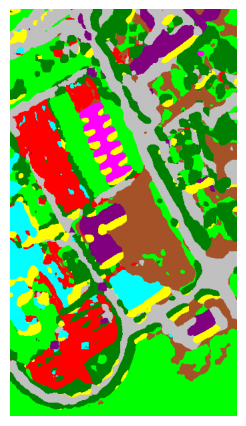

In [20]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './pu_massformer.pdf')